# Gdelt News
https://blog.gdeltproject.org/gdelt-2-0-our-global-world-in-realtime/

All news in gkg with one theme containing "mitigation", "environment", "climate", "env_", "natural_disaster”. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path += ["../src"]
import climact_utils as cu
import seaborn as sns
from matplotlib.pyplot import subplots as sbp
import numpy as np
from glob import glob
import json
import re
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import spark_init
sc = spark_init.spark_context()

def resilient_json(s):
    try:
        return json.loads(s)
    except:
        return {}
    


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


#### Total news GDelt per day

In [4]:
daily_news = pd.read_csv(cu.data_path + "count_all_gdelt_news.csv", index_col = 0)
daily_news["date"] = pd.to_datetime(daily_news["date"])
daily_news = daily_news.assign(str_date = lambda x: [u.strftime("%Y_%m_%d") for u in x["date"]])

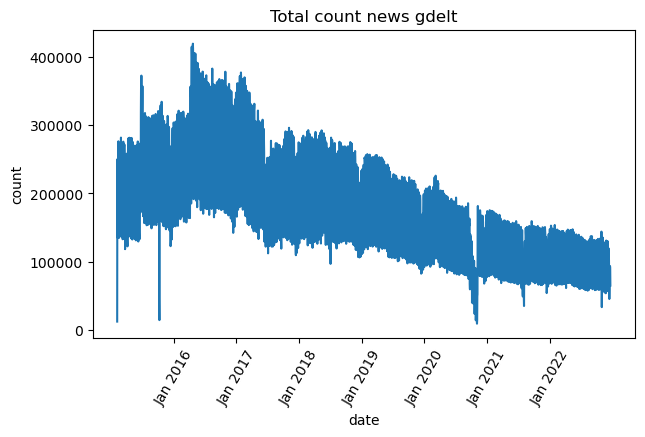

In [5]:
fig, axes = sbp(figsize = (7,4))

sns.lineplot(data = daily_news, x = "date", y = "count", ax = axes)
axes.set_xticks(daily_news.iloc[330::365]["date"])
axes.set_xticklabels(daily_news.iloc[330::365]["date"].dt.strftime("%b %Y"), rotation = 60)
axes.set_title("Total count news gdelt")
fig.show()

#### Geolocation news
Extract countries and provinces/states. 
We need only the ones in US and Canada, so we match the strings in "V2Locations".

In [11]:
v2Loc = pd.read_csv(sorted(glob(cu.data_path + "gdelt_climate_themes/2019_09_26*"))[0])["V2Locations"].head(10)

In [13]:
def get_us_states_and_ca_region(line):
    pattern = "(US\w\w|CA\d\d)$"
    return list(set([(split_u[:2], split_u[2:]) for u in line.split(";") 
            for split_u in u.split("#") if re.match(pattern = pattern, string = split_u)])) if line == line else []

#### Themes

In [6]:
themes_day = pd.read_csv(sorted(glob(cu.data_path + "gdelt_climate_themes/2019_09_26*"))[0])["V2Themes"]

Climate related themes

In [7]:
", ".join(pd.Series([k for u in themes_day for k in u.replace(",", ";").split(";") if ("CLIMATE" in k)]).value_counts().index[:100])

'UNGP_CLIMATE_CHANGE_ACTION, ENV_CLIMATECHANGE, WB_567_CLIMATE_CHANGE, WB_405_BUSINESS_CLIMATE, WB_1949_CLIMATE_SMART_AGRICULTURE, WB_579_CLIMATE_CHANGE_MITIGATION, WB_571_CLIMATE_SCIENCE, WB_1844_MARKET_BASED_CLIMATE_CHANGE_MITIGATION, WB_1841_SHORT_LIVED_CLIMATE_POLLUTANTS, WB_1773_CLIMATE_CHANGE_IMPACTS, WB_568_CLIMATE_SERVICES, WB_1847_CLIMATE_FINANCE, WB_747_SOCIAL_RESILIENCE_AND_CLIMATE_CHANGE, WB_959_CLIMATE_CHANGE_LAW, WB_574_CLIMATE_CHANGE_ADAPTATION, WB_2673_JOBS_AND_CLIMATE_CHANGE, WB_1774_CLIMATE_FORECASTING, TAX_AIDGROUPS_CLIMATE_ACTION_NETWORK, WB_572_CLIMATE_RESILIENT_DEVELOPMENT, WB_2639_CLIMATE_EFFICIENT_INDUSTRIES, WB_573_CLIMATE_RISK_MANAGEMENT, WB_1838_CLIMATE_RISK_SCREENING'

Natural disaster themes

In [8]:
pd.Series([k[17:] for u in themes_day for k in u.replace(",", ";").split(";") if ("NATURAL_DISASTER" in k)]).value_counts().index[:100]

Index(['ICE', 'EARTHQUAKE', 'HURRICANE', 'FLOODING', 'DROUGHT', 'FLOOD',
       'TSUNAMI', 'FLOODS', 'FLOODED', 'EARTHQUAKES', 'TROPICAL_STORM',
       'EROSION', 'WILDFIRES', 'WILDFIRE', 'HURRICANES', 'NATURAL_DISASTERS',
       'TREMOR', 'HEAVY_RAIN', 'HEAVY_RAINS', 'MONSOON', 'VOLCANIC', 'TORNADO',
       'LANDSLIDE', 'EXTREME_WEATHER', 'DROWNING', 'DROWNED', 'AFTERSHOCKS',
       'CYCLONE', 'HEATWAVES', 'ICY', 'FAMINE', 'TREMORS', 'CHILL',
       'SUSTAINED_WINDS', 'FOREST_FIRES', 'SEVERE_WEATHER', 'TEMBLOR', 'DROWN',
       'DROUGHTS', 'WINTER_STORM', 'AFTERSHOCK', 'STRONG_WINDS', 'LANDSLIDES',
       'SMOG', 'CYCLONES', 'ERUPTION', 'HEAT_WAVES', 'ERUPTIONS', 'HIGH_WATER',
       'LOCUST', 'RICHTER_SCALE', 'BLIZZARD', 'WATER_LEVEL', 'FLOOD_WATERS',
       'NATURAL_DISASTER', 'VOLCANO', 'AVALANCHE', 'TYPHOON', 'FLASH_FLOOD',
       'FLASH_FLOODS', 'FLOODWATERS', 'STORM_SURGE', 'VOLCANOES', 'TORNADOES',
       'FREEZING_TEMPERATURES', 'HEAT_WAVE', 'HIGH_WINDS', 'TROPICAL_CYCLONE',
 

#### News transformation
For each day count the number of news in each category and in each admin.

In [27]:
def get_data_strike_natural_disaster_admin(date):
    # date in format 2017_01_01
    df = pd.read_csv(sorted(glob(cu.data_path + f"gdelt_climate_themes/{date}*"))[0])\
        .assign(admin1code = lambda x: [list(set(get_us_states_and_ca_region(u))) for u in x["V2Locations"]],
                is_strike = lambda x: ["STRIKE" in u.replace(",", ";").split(";") for u in x["V2Themes"]], # want exact match, theme STRIKE
                is_climate_action = lambda x: ["UNGP_CLIMATE_CHANGE_ACTION" in u for u in x["V2Themes"]], 
                is_climate = lambda x: ["CLIMATE" in u for u in x["V2Themes"]],
                is_natural_disaster = lambda x: ["NATURAL_DISASTER" in u for u in x["V2Themes"]])[["admin1code","is_strike","is_climate_action","is_natural_disaster"]]\
                    .explode("admin1code").dropna().value_counts().reset_index()\
                        .assign(country = lambda x: [u[0] for u in x["admin1code"]],
                                region = lambda x: [u[1] for u in x["admin1code"]],
                                norm_count = lambda x: x["count"] / daily_news.set_index("str_date").loc[date,"count"])
    return df
                                

In [30]:
get_data_strike_natural_disaster_admin("2019_01_01")

,admin1code,is_strike,is_climate_action,is_natural_disaster,count,country,region,norm_count
0,"(US, NY)",False,False,True,1308,US,NY,0.010607
1,"(US, CA)",False,False,False,1296,US,CA,0.010510
2,"(US, CA)",False,False,True,1069,US,CA,0.008669
3,"(US, MD)",False,False,True,1065,US,MD,0.008637
4,"(US, DC)",False,False,True,855,US,DC,0.006934
...,...,...,...,...,...,...,...,...
316,"(US, SD)",False,True,True,1,US,SD,0.000008
317,"(US, TN)",False,True,False,1,US,TN,0.000008
318,"(US, TN)",False,True,True,1,US,TN,0.000008
319,"(US, TX)",True,True,True,1,US,TX,0.000008


#### News Volume time series

In [31]:
region = "NY"
region_news_count = pd.concat([pd.read_csv(file, index_col = 0).query("region == @region").assign(date_str = file.replace(".", "/").split("/")[-2], 
                                                                                           date = pd.to_datetime(file.replace(".", "/").split("/")[-2].replace("_", ""))) for file in sorted(glob(cu.data_path + f"us_canada_news_daily_count/*.csv"))])

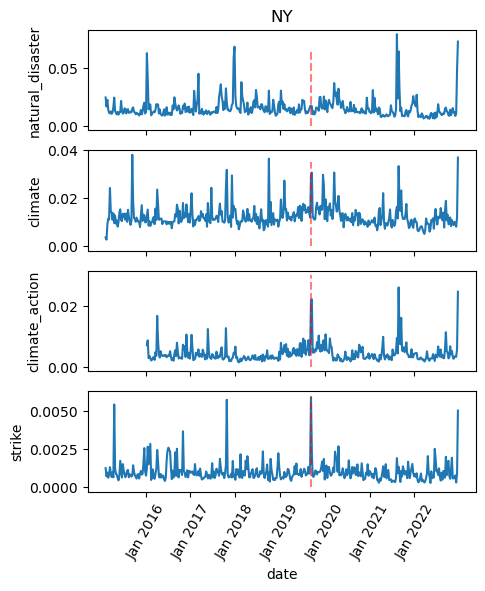

In [32]:
fig, axes = sbp(figsize = (5,6), ncols = 1, nrows = 4, sharex = True)

y_max_red_line = [.065, 0.035, 0.03, 0.006]
for i, var in enumerate(["is_natural_disaster", "is_climate", "is_climate_action", "is_strike"]):
    sns.lineplot(data = region_news_count.query(var).groupby("date").sum(numeric_only = True).reset_index()\
                 .groupby([pd.Grouper(key = 'date', freq = 'w')])['norm_count'].mean().reset_index(),
                 x = "date", y = "norm_count", ax = axes[i])
    axes[i].set_ylabel(var[3:])
    axes[i].set_xticks(daily_news.iloc[330::365]["date"])
    axes[i].set_xticklabels(daily_news.iloc[330::365]["date"].dt.strftime("%b %Y"), rotation = 60)
    axes[i].vlines(x = pd.to_datetime("2019-09-21"), ymin = 0, ymax = y_max_red_line[i], 
                   colors = "red", alpha = 0.5, linestyles = "dashed")
    axes[0].set_title(region)

fig.show()


